In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import math
import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.utils import class_weight
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.models import load_model
import joblib
# import py_vollib.black_scholes.implied_volatility
import multiprocessing
from multiprocessing import Pool
import os
# import py_vollib.black_scholes.implied_volatility as vb
%matplotlib inline

Using TensorFlow backend.
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tenso

In [2]:
# Path settings


path_var = 2 

if (path_var == 1):
    filepath = '/home/docboy/Desktop/Option_Pricing/datasets/'
    modelpath = '/home/docboy/Desktop/Option_Pricing/pickles/'


else:
    filepath = '/home/sharan/Desktop/OptionPricing-master/datasets/'
    modelpath = '/home/sharan/Desktop/OptionPricing-master/pickles/'



nfty = filepath + 'NIFTY50_feature_set_COV_complete.csv'
nfty_ecdf = filepath + 'NIFTY50_feature_set_ECDF_complete.csv'
    
bnfty = filepath + 'BANKNIFTY_feature_set_COV_complete.csv'
bnfty_ecdf = filepath + 'BANKNIFTY_feature_set_ECDF_complete.csv'


In [3]:
# Set the automated variables + Plus drop all useless columns approach specific


###########################
###############################################

approach = 3                      #------------------>>> # Change value as needed

###############################################
###########################


if (approach == 1):
    feats = pd.read_csv(nfty_ecdf)
    print ('Approach var set to ECDF')
    
    dropNames = ['date','percentage','strike','spot','opPrice']
    
    b_feats = pd.read_csv(bnfty_ecdf)
    
else:
    feats = pd.read_csv(nfty)
    print ('Approach var set to :: '+ str(approach))
    
    b_feats = pd.read_csv(bnfty)
    
    if (approach == 2):
        dropNames= ['date','percentage','strike','spot','opPrice','change_oi','ts_atr','prevOp','avg_atmError']
        
    else:
        dropNames= ['date', 'percentage','strike','spot','opPrice','ts_atr','change_oi']
        
###################

X=feats.iloc[:,:-1]
Y=feats.loc[:,'Target']
X = X.drop(dropNames, axis = 1)    



b_X = b_feats.iloc[:,:-1]
b_Y = b_feats.loc[:,'Target']
b_X = b_X.drop(dropNames, axis = 1)    




Approach var set to :: 3


In [4]:
X.columns

Index(['close_mean', 'close_sd', 'open_mean', 'open_sd', 'high_mean',
       'high_sd', 'low_mean', 'low_sd', 'close_lr_open_lr_cov',
       'close_lr_high_lr_cov', 'close_lr_low_lr_cov', 'open_lr_high_lr_cov',
       'open_lr_low_lr_cov', 'high_lr_low_lr_cov', 'avg_atmError', 'prevOp',
       'ttm', 'atmError', 'yield03'],
      dtype='object')

In [5]:
# Start the scaling process

featNames = list(X)  
scaler = RobustScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = featNames)


In [6]:
# # Save the scalar file

joblib.dump(scaler, modelpath + 'DL_SCALER_NIFTY_0.02_Expt' + str(approach) + '.model')
print("Scaler saved to path ::", modelpath + 'DL_SCALER_NIFTY_0.02_Expt' + str(approach) + '.model' )

Scaler saved to path :: /home/sharan/Desktop/OptionPricing-master/pickles/DL_SCALER_NIFTY_0.02_Expt3.model


In [7]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y),Y)
print(class_weights)

[0.35568421 0.4152381  0.47341506 0.49782689 0.53003922 0.54390342
 0.59280702 0.59673289 0.66745679 0.64515513 0.71893617 0.79976331
 0.76795455 0.83950311 0.88339869 0.86089172 0.9723741  0.91324324
 0.98656934 1.05182879 1.14542373 0.96542857 1.08128    1.17530435
 1.32509804 1.24571429 1.15521368 1.22872727 1.48527473 1.33821782
 1.36525253 1.3516     1.57162791 1.6895     1.51865169 1.63830303
 1.41528796 1.48527473 1.63830303 1.86427586 1.89034965 1.91716312
 1.89034965 1.97313869 2.67643564 3.03730337 3.51064935 4.15876923
 4.74245614 1.55356322]


In [8]:
onehot = OneHotEncoder(sparse=False)
Y = Y.values
Y = Y.reshape(len(Y), 1)
Y = onehot.fit_transform(Y)
joblib.dump(onehot, modelpath + 'DL_ONEHOT_NIFTY_0.02_Expt' + str(approach) + '.model')

['/home/sharan/Desktop/OptionPricing-master/pickles/DL_ONEHOT_NIFTY_0.02_Expt3.model']

In [9]:
# Split the train and test sets without random optimizations


a = len(feats)
split_val = round(a*0.8)

# Removing the Random splits

X_train = X.iloc[0:split_val, :]
X_test = X.iloc[split_val:, :]
Y_train = Y[:split_val]
Y_test = Y[split_val:]
print ('X & Y_Dim of Train is', X_train.shape, Y_train.shape)
print ('X & Y_Dim of Test is', X_test.shape, Y_test.shape)




X & Y_Dim of Train is (10813, 19) (10813, 50)
X & Y_Dim of Test is (2703, 19) (2703, 50)


In [10]:
opt=optimizers.Adam(lr=0.00012);
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=128, activation='relu',input_dim=X_train.shape[1]))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(units=128, activation='relu'))
# model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(units=64, activation='relu'))
# model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(units=50, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],)
history=model.fit(X_train, Y_train,
  batch_size=32,
  epochs=60,
  verbose=1,
#   class_weight=class_weights,
  validation_data=(X_test, Y_test),
  shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2560      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3250      
Total params: 14,066
Trainable params: 14,066
Non-trainable params: 0
_________________________________________________________________
Train on 10813 samples, validate on 2703 samples
Epoch 1/60
10813/10813 [==============================] - 1s 126us/step - loss: 3.8707 - acc: 0.0437 - val_loss: 3.7310 - val_acc: 0.0799
Epoch 2/60
10813/10813 [==============================] - 1s 61us/step - loss: 3.6093 - acc: 0.0662 - val_loss: 3.3838 - val_acc: 0.0825
Epoch 3/60
10813/10813 [==============================] - 1s 54us/step - loss:

Epoch 55/60
10813/10813 [==============================] - 1s 59us/step - loss: 1.7122 - acc: 0.3632 - val_loss: 1.9131 - val_acc: 0.2760
Epoch 56/60
10813/10813 [==============================] - 1s 57us/step - loss: 1.7067 - acc: 0.3713 - val_loss: 1.9071 - val_acc: 0.2704
Epoch 57/60
10813/10813 [==============================] - 1s 58us/step - loss: 1.7021 - acc: 0.3661 - val_loss: 1.9078 - val_acc: 0.2767
Epoch 58/60
10813/10813 [==============================] - 1s 57us/step - loss: 1.6980 - acc: 0.3682 - val_loss: 1.9008 - val_acc: 0.2764
Epoch 59/60
10813/10813 [==============================] - 1s 58us/step - loss: 1.6940 - acc: 0.3691 - val_loss: 1.9065 - val_acc: 0.2701
Epoch 60/60
10813/10813 [==============================] - 1s 59us/step - loss: 1.6890 - acc: 0.3727 - val_loss: 1.8964 - val_acc: 0.2834


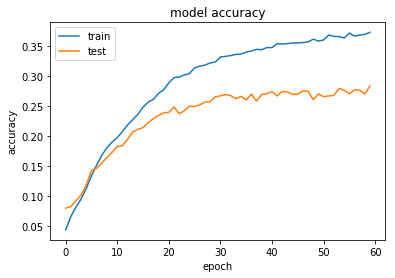

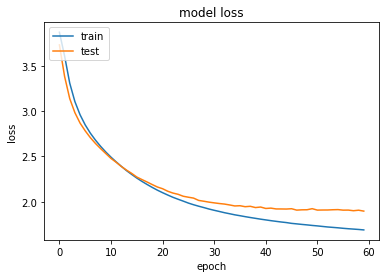

In [11]:
if(path_var ==1):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

elif(path_var==2):

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1]*100)

Y_pred=model.predict(X_test)
Y_pred=np.argmax(Y_pred,axis=1)

Test accuracy: 28.33888273061843


In [13]:
OGY_test=onehot.inverse_transform(Y_test)
# OGY_test=sum(OGY_test, [])
OGY_test=OGY_test.ravel()
# print(OGY_test)

# # Check if Binwidth value exists
maxVal=5
minVal=0

width = maxVal - minVal

num_bins = 50


bin_width = width/num_bins
# print(bin_width)

# Normalized Error Metric (NEM)

dist_sum = 0
for i in range(len(Y_pred)):
    dist = abs(Y_pred[i] - OGY_test[i])
    dist_sum = dist_sum + dist
    
print((dist_sum*bin_width)/len(Y_test))

0.13984461709211987


In [14]:
# Saving the model
joblib.dump(model, modelpath + 'DL_NIFTY_0.02_Expt' + str(approach) + '.model')
print("Model saved to path ::", modelpath + 'DL_NIFTY_0.02_Expt' + str(approach) + '.model' )

Model saved to path :: /home/sharan/Desktop/OptionPricing-master/pickles/DL_NIFTY_0.02_Expt3.model


In [15]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(OGY_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       197
           1       0.45      0.49      0.47       162
           2       0.35      0.41      0.38       133
           3       0.31      0.29      0.30       119
           4       0.29      0.28      0.28       108
           5       0.21      0.17      0.19       106
           6       0.26      0.25      0.25        93
           7       0.24      0.35      0.28        92
           8       0.19      0.18      0.19        78
           9       0.23      0.20      0.21        86
          10       0.23      0.30      0.26        70
          11       0.28      0.12      0.16        68
          12       0.25      0.35      0.29        60
          13       0.07      0.02      0.03        63
          14       0.20      0.23      0.21        62
          15       0.18      0.31      0.23        52
          16       0.15      0.13      0.14        55
          17       0.12    

/home/sharan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Port Part

In [16]:
### Begin Port Part

# Scale the dataset according to saved scaler

featNames = list(b_X)
b_X = scaler.transform(b_X)
b_X = pd.DataFrame(b_X, columns = featNames)


# Generate Class weights

class_weights = class_weight.compute_class_weight('balanced',np.unique(b_Y),b_Y)


# Port the Onehot tranform
b_Y = b_Y.values
b_Y = b_Y.reshape(len(b_Y), 1)
b_Y = onehot.transform(b_Y)




# Split the train and test sets without random optimizations


b_X_test = b_X.iloc[:, :]
b_Y_test = b_Y[:]
print ('b_X & b_Y_Dim of Test is', b_X_test.shape, b_Y_test.shape)


b_X & b_Y_Dim of Test is (20414, 19) (20414, 50)


In [17]:
score = model.evaluate(b_X_test, b_Y_test, verbose=0)
print('Test accuracy:', score[1]*100)

b_Y_pred=model.predict(b_X_test)
b_Y_pred=np.argmax(b_Y_pred,axis=1)

Test accuracy: 21.279514061022986


In [18]:
b_OGY_test = onehot.inverse_transform(b_Y_test)
b_OGY_test = b_OGY_test.ravel()

# Check if Binwidth value exists
maxVal=5
minVal=0

width = maxVal - minVal

num_bins = 50


bin_width = width/num_bins
# print(bin_width)

# Normalized Error Metric (NEM)

dist_sum = 0
for i in range(len(b_Y_pred)):
    dist = abs(b_Y_pred[i] - b_OGY_test[i])
    dist_sum = dist_sum + dist
    
print((dist_sum*bin_width)/len(b_Y_test))

0.23196335847947488


DL_NEM = []
DL_D_NEM = []

path="/home/sharan/Desktop/Option Pricing Work/Work/Serial GBM Runs/"

sigma = np.linspace(0.01, 0.2, 20)

for si in sigma:
    si=round(si,2)
    feats = pd.read_csv(path+"GBM_feature_set_final_ecdf_"+str(si)+".csv")
    X=feats.iloc[:,:-1]
    X['atmError']=X['atmError']*100
    Y=feats.loc[:,'Target']
    dr = ['percentage']
    X = X.drop(dr, axis = 1)
    featNames=list(X)
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=featNames)
    
    Y = Y.values
    
    Y_pred = model.predict(X)
    Y_pred = np.argmax(Y_pred,axis=1)
    
    dist_sum = 0
    d_dist_sum = 0
    for i in range(len(Y_pred)):
        dist = abs(Y_pred[i] - Y[i]) # NEM
        d_dist = (Y_pred[i] - Y[i]) # Directional NEM (NEM without the mod)
        
        dist_sum = dist_sum + dist # NEM
        d_dist_sum = d_dist_sum + d_dist
    
    nem = (dist_sum*bin_width)/len(Y)*100
    d_nem = (d_dist_sum*bin_width)/len(Y)*100
    
    DL_NEM.append(nem)
    DL_D_NEM.append(d_nem)
    
dresults=pd.DataFrame({'sigma' : sigma, 
              'nem': DL_NEM, 
              'd_nem' : DL_D_NEM})
dresults.to_csv(path+"DresultsGBM.csv" ,index=False)    

DL_NEM = []
DL_D_NEM = []
path="/home/sharan/Desktop/Option Pricing Work/Work/Binomial/"

U=[]
D=[]
for i in range(1,10):
    u=1+(i*pow(10,-3))
    d=1/u
    U.append(u)
    D.append(d)

for u in U:
    u=round(u,5)
    feats = pd.read_csv(path+"BM_feature_set_final_ecdf_"+str(u)+".csv")
    X=feats.iloc[:,:-1]
    X['atmError']=X['atmError']*100
    Y=feats.loc[:,'Target']
    dr = ['percentage']
    X = X.drop(dr, axis = 1)
    featNames=list(X)    
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=featNames)
    
    Y = Y.values
    
    Y_pred = model.predict(X)
    Y_pred = np.argmax(Y_pred,axis=1)
    
    dist_sum = 0
    d_dist_sum = 0
    for i in range(len(Y_pred)):
        dist = abs(Y_pred[i] - Y[i]) # NEM
        d_dist = (Y_pred[i] - Y[i]) # Directional NEM (NEM without the mod)
        
        dist_sum = dist_sum + dist # NEM
        d_dist_sum = d_dist_sum + d_dist
    
    nem = (dist_sum*bin_width)/len(Y)*100
    d_nem = (d_dist_sum*bin_width)/len(Y)*100
    
    DL_NEM.append(nem)
    DL_D_NEM.append(d_nem)
    
dresults=pd.DataFrame({'U' : U, 
              'nem': DL_NEM, 
              'd_nem' : DL_D_NEM})
dresults.to_csv(path+"DresultsBM.csv" ,index=False)    

def worker(date,UnderlyingPrice, StrikePrice, InterestRate, Daystoexpiration,l_callPrice,h_callPrice,a_callPrice):
#     implied_volatility(price, S, K, t, r, flag)
#     l_iv=vb.implied_volatility(l_callPrice, UnderlyingPrice, StrikePrice, Daystoexpiration/365, InterestRate/100, 'c')
#     h_iv=vb.implied_volatility(h_callPrice, UnderlyingPrice, StrikePrice, Daystoexpiration/365, InterestRate/100, 'c')
    a_iv=vb.implied_volatility(a_callPrice, UnderlyingPrice, StrikePrice, Daystoexpiration/365, InterestRate/100, 'c')
    return [date,a_iv]

test_latest_ecdf="/home/sharan/Desktop/Option Pricing Work/Work/nifty_19-20_feature_set_ecdf_new_FINAL.csv"
latest_ecdf_feats = pd.read_csv(test_latest_ecdf)

dropNames = ['date', 'percentage','strike','spot','opPrice']

X_latest=latest_ecdf_feats.iloc[:,:-1]
Y_latest=latest_ecdf_feats.loc[:,'Target']
X_latest = X_latest.drop(dropNames, axis = 1)

featNames = list(X_latest)  
X_latest = scaler.transform(X_latest)
X_latest = pd.DataFrame(X_latest, columns = featNames)
Y_latest = Y_latest.values
Y_latest = Y_latest.reshape(len(Y_latest), 1)
Y_latest = onehot.transform(Y_latest)
score = model.evaluate(X_latest, Y_latest, verbose=0)

Y_latest_pred=model.predict(X_latest)
Y_latest_pred=np.argmax(Y_latest_pred,axis=1)

OGY_latest=onehot.inverse_transform(Y_latest)

OGY_latest=OGY_latest.ravel()
# print(OGY_latest_test)

# # Check if Binwidth value exists
maxVal=5
minVal=0

width = maxVal - minVal

num_bins = 50


bin_width = width/num_bins
# print(bin_width)


dist_sum = 0
step = 0.1

date=[]
lower_iv=[]
higher_iv=[]
actual_iv=[]

params=[]

total_res=[]

for i in range(len(Y_latest_pred)):    
    
    lower_bound_opPrice = ((Y_latest_pred[i]*step) * latest_ecdf_feats.loc[i,'strike'])/100
    
    higher_bound_opPrice = (( (Y_latest_pred[i]+1) * step) * latest_ecdf_feats.loc[i,'strike'])/100
    
    actual_opPrice = latest_ecdf_feats.loc[i,'opPrice']
    
    print("\nDate={}".format(latest_ecdf_feats.loc[i,'date']))
    print("Lower={}".format(lower_bound_opPrice))
    print("Higher={}".format(higher_bound_opPrice))
    print("Actual={}".format(actual_opPrice))    
    print("S={}".format(latest_ecdf_feats.loc[i,'spot']))
    print("K={}".format(latest_ecdf_feats.loc[i,'strike']))
    print("TTM={}".format(latest_ecdf_feats.loc[i,'ttm']))
    print("R={}".format(latest_ecdf_feats.loc[i,'yield03']))    
    
#     params.append((latest_ecdf_feats.loc[i,'date'],latest_ecdf_feats.loc[i,'spot'], 
#                    latest_ecdf_feats.loc[i,'strike'],
#                    latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm'],
#                   lower_bound_opPrice,higher_bound_opPrice,actual_opPrice))

    res_list=worker(latest_ecdf_feats.loc[i,'date'],latest_ecdf_feats.loc[i,'spot'], 
                   latest_ecdf_feats.loc[i,'strike'],
                   latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm'],
                  lower_bound_opPrice,higher_bound_opPrice,actual_opPrice)
    
    total_res.append(res_list)
#     break

# IV=[]
# pool = Pool()
# for res in pool.starmap(worker,params):    
#     IV.append(res)
    
# pool.close()


    
#     date.append(latest_ecdf_feats.loc[i,'date'])
    
#     lower_bound_opPrice = ((Y_latest_pred[i]*step) * latest_ecdf_feats.loc[i,'strike'])/100
#     print("\nLower={}".format(lower_bound_opPrice))
# #     print("OpPrice={}".format(lower_bound_opPrice))
# #     print("S={}".format(latest_ecdf_feats.loc[i,'spot']))
# #     print("K={}".format(latest_ecdf_feats.loc[i,'strike']))
# #     print("TTM={}".format(latest_ecdf_feats.loc[i,'ttm']/365))
# #     print("R={}".format(latest_ecdf_feats.loc[i,'yield03']))
#     #BS([UnderlyingPrice, StrikePrice, InterestRate, Daystoexpiration],callPrice=x)
#     l_iv = mibian.BS([latest_ecdf_feats.loc[i,'spot'], latest_ecdf_feats.loc[i,'strike'],
#                    latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm']],
#                                callPrice=lower_bound_opPrice)

#     lower_iv.append(l_iv.impliedVolatility)
#     print(lower_iv)
    
#     higher_bound_opPrice = (( (Y_latest_pred[i]+1) * step) * latest_ecdf_feats.loc[i,'strike'])/100
#     print("Higher={}".format(higher_bound_opPrice))
    
#     h_iv = mibian.BS([latest_ecdf_feats.loc[i,'spot'], latest_ecdf_feats.loc[i,'strike'],
#                    latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm']],
#                                callPrice=higher_bound_opPrice)
    
#     higher_iv.append(h_iv.impliedVolatility)
#     print(higher_iv)

#     actual_opPrice = latest_ecdf_feats.loc[i,'opPrice']
#     print("Actual={}".format(actual_opPrice))
    
#     a_iv = mibian.BS([latest_ecdf_feats.loc[i,'spot'], latest_ecdf_feats.loc[i,'strike'],
#                    latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm']],
#                                callPrice=actual_opPrice)
    
#     actual_iv.append(a_iv.impliedVolatility)    
#     print(actual_iv)
#     break

vola_names=['Date','LowerBoundIV','HigherBoundIV','ActualIV']
vola_dataSet=pd.DataFrame.from_records(IV, columns=vola_names)
vola_dataSet

Lower=317.8
Higher=329.1500000000001
Actual=324.8
S=11713.2
K=11350.0
TTM=2.0
R=6.18